In [2]:
import numpy as np
from torch.nn import functional as F
from torch import nn
import torch as th
from torchvision.utils import draw_bounding_boxes
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes

In [3]:
device=th.device("cuda" if th.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
image_set = np.load("/kaggle/input/multimnistm2nist/combined.npy")
masks_set = np.load("/kaggle/input/multimnistm2nist/segmented.npy")

In [5]:
import numpy as np


pixel_counts = masks_set.sum(axis=(1, 2))  # shape: (5000, 11)
digit_counts = pixel_counts[:, :10]  # shape: (5000, 10)
digitwise_stats = {}

for d in range(10):
    # Get all non-zero counts for digit d
    counts = digit_counts[:, d]
    nonzero_counts = counts[counts != 0]
    
    if nonzero_counts.size > 0:
        stats = {
            "mean": float(nonzero_counts.mean()),
            "median": float(np.median(nonzero_counts)),
            "min": int(nonzero_counts.min()),
            "max": int(nonzero_counts.max()),
            "nonzero_count": int(nonzero_counts.size)  # how many images had this digit
        }
    else:
        stats = {
            "mean": 0.0,
            "median": 0.0,
            "min": 0,
            "max": 0,
            "nonzero_count": 0
        }
    digitwise_stats[d] = stats

# Print results:
for d in range(10):
    print(f"Digit {d}: {digitwise_stats[d]}")


Digit 0: {'mean': 201.263557483731, 'median': 190.0, 'min': 106, 'max': 535, 'nonzero_count': 922}
Digit 1: {'mean': 91.2451923076923, 'median': 85.0, 'min': 40, 'max': 244, 'nonzero_count': 1040}
Digit 2: {'mean': 177.59607438016528, 'median': 172.0, 'min': 90, 'max': 503, 'nonzero_count': 968}
Digit 3: {'mean': 172.40226337448559, 'median': 166.0, 'min': 68, 'max': 419, 'nonzero_count': 972}
Digit 4: {'mean': 150.38520130576714, 'median': 144.0, 'min': 70, 'max': 507, 'nonzero_count': 919}
Digit 5: {'mean': 161.3300760043431, 'median': 151.0, 'min': 73, 'max': 561, 'nonzero_count': 921}
Digit 6: {'mean': 167.94460641399417, 'median': 160.0, 'min': 81, 'max': 420, 'nonzero_count': 1029}
Digit 7: {'mean': 141.0979020979021, 'median': 134.0, 'min': 66, 'max': 386, 'nonzero_count': 1001}
Digit 8: {'mean': 185.50414078674947, 'median': 174.0, 'min': 99, 'max': 543, 'nonzero_count': 966}
Digit 9: {'mean': 150.53478712357216, 'median': 142.0, 'min': 77, 'max': 382, 'nonzero_count': 963}


In [6]:
print(image_set[0].max())
print(masks_set[0][:,:,2].max())

255
1


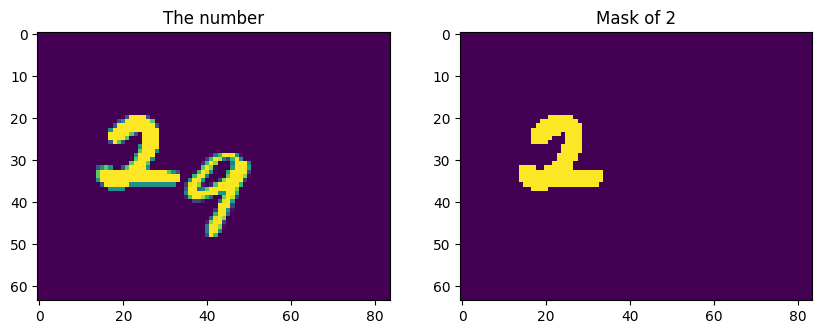

In [7]:
fig = plt.figure(figsize=(10,7))
plt.subplot(1,2,1)
plt.imshow(image_set[0])
plt.title("The number")
plt.subplot(1,2,2)
plt.imshow(masks_set[0][:,:,2])
plt.title("Mask of 2")
plt.show()

In [8]:
conv1 = nn.Sequential( nn.Conv2d(1,64,kernel_size=(3,3)),
                      ## current state: 64*62*166
                      nn.Conv2d(64,64,kernel_size=(3,3)),
                      ## current : 64x60×164
                     )
maxpool1 = nn.MaxPool2d(kernel_size=(2,2))
## current 64x30x82

conv2 = nn.Sequential( 
            nn.Conv2d(64,128,kernel_size=(3,3)),
            nn.Conv2d(128,128,kernel_size=(3,3)),
)
## 128,26,78
maxpool2 = nn.MaxPool2d(kernel_size=(2,2))
## current 128,13,39

convtr2 = nn.Sequential( nn.ConvTranspose2d(128,128,kernel_size=(2,2),stride=(2,2)),
                     )
## current 128,26,78
convtr1 = nn.Sequential( nn.ConvTranspose2d(128,64,kernel_size=(10,10),stride=(2,2)),
                     )

maskconv = nn.Sequential(
    nn.ConvTranspose2d(64,64,kernel_size=(3,3)),
    nn.ConvTranspose2d(64,11,kernel_size=(3,3)),
)

print(convtr1(convtr2(maxpool2(conv2(maxpool1(conv1(th.randn(size=(1,1,64,168)))))))).shape)
print(conv1(th.randn(size=(1,1,64,168))).shape)
print(maskconv(convtr1(convtr2(maxpool2(conv2(maxpool1(conv1(th.randn(size=(1,1,64,168))))))))).shape)

torch.Size([1, 64, 60, 164])
torch.Size([1, 64, 60, 164])
torch.Size([1, 11, 64, 168])


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=11):
        super(UNet, self).__init__()
        
        # --- Encoder (Downsampling path) ---
        # Block 1
        self.down_conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Block 2
        self.down_conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # --- Bottleneck ---
        self.bottleneck = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        
        # --- Decoder (Upsampling path) ---
        # Up Block 2
        self.up_trans2 = nn.ConvTranspose2d(
            in_channels=256, out_channels=128, 
            kernel_size=2, stride=2
        )
        self.up_conv2 = nn.Sequential(
            nn.Conv2d(128 + 128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        
        # Up Block 1
        self.up_trans1 = nn.ConvTranspose2d(
            in_channels=128, out_channels=64, 
            kernel_size=2, stride=2
        )
        self.up_conv1 = nn.Sequential(
            nn.Conv2d(64 + 64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        
        # --- Output Convolution ---
        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        
    def forward(self, x):
        # --- Encoder ---
        # Block 1
        x1 = self.down_conv1(x)         # [N, 64, H, W]
        x1p = self.pool1(x1)            # [N, 64, H/2, W/2]
        
        # Block 2
        x2 = self.down_conv2(x1p)       # [N, 128, H/2, W/2]
        x2p = self.pool2(x2)            # [N, 128, H/4, W/4]
        
        # --- Bottleneck ---
        x3 = self.bottleneck(x2p)       # [N, 256, H/4, W/4]
        
        # --- Decoder ---
        # Up Block 2
        x2_up = self.up_trans2(x3)      # [N, 128, H/2, W/2]
        x2_cat = torch.cat([x2_up, x2], dim=1)  # [N, 256, H/2, W/2]
        x2d = self.up_conv2(x2_cat)     # [N, 128, H/2, W/2]
        
        # Up Block 1
        x1_up = self.up_trans1(x2d)     # [N, 64, H, W]
        x1_cat = torch.cat([x1_up, x1], dim=1)  # [N, 128, H, W]
        x1d = self.up_conv1(x1_cat)     # [N, 64, H, W]
        
        # --- Output ---
        out = self.out_conv(x1d)        # [N, out_channels, H, W]
        return out


In [10]:
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights
from torch.utils.data import Dataset,DataLoader

weights = FCN_ResNet50_Weights.DEFAULT
transforms = weights.transforms(resize_size=None)

model = fcn_resnet50(weights=weights, progress=False)
model = model.eval()

Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth


In [11]:
padding = (42,42)
class MultiDigitDataset(Dataset):
    def __init__(self,images,masks):
        self.images = images 
        self.masks = masks
    def __len__(self):
        return(len(self.images[:,1]))
    def __getitem__(self,idx):
        image = self.images[idx]
        std = np.std(image)
        image = (image-np.mean(image))/std
        image_tensor = th.tensor(image, dtype=th.float32)
        image_tensor = th.nn.functional.pad(image_tensor,padding,mode="constant"
                                           ,value=0)
        masks = th.tensor(self.masks[idx],dtype=th.float32).permute(2,0,1)
        masks = th.nn.functional.pad(masks,padding,mode="constant"
                                           ,value=0)
        return(image_tensor.unsqueeze(0),masks)
        
        

In [12]:
from sklearn.model_selection import train_test_split
dset =  MultiDigitDataset(image_set,masks_set)


train_img, test_img, train_masks, test_masks = train_test_split(
    image_set,
    masks_set,
    test_size=0.2
)

train_img, val_img, train_masks, val_masks = train_test_split(
    train_img, 
    train_masks, 
    test_size=0.2,  # or train_size=0.8
)



In [13]:
trset = MultiDigitDataset(train_img,train_masks)
valset = MultiDigitDataset(val_img,val_masks)
teset = MultiDigitDataset(test_img,test_masks)

train_loader = DataLoader(trset,batch_size=32)
test_loader = DataLoader(teset,batch_size=32)
val_loader = DataLoader(valset,batch_size=32)

In [14]:
import torch

def compute_pixel_accuracy(pred_labels, true_labels):
    """
    Overall Pixel Accuracy:
    (# of correct pixels) / (total # of pixels)
    pred_labels: [N, H, W], int
    true_labels: [N, H, W], int
    """
    correct = (pred_labels == true_labels).sum().float()
    total = true_labels.numel()
    return correct / (total + 1e-8)

def compute_iou_per_class(pred_labels, true_labels, num_classes):
    """
    Computes IoU (Jaccard Index) for each class c in [0..num_classes-1].
    Returns a tensor [num_classes], each entry is IoU for that class.
    """
    ious = []
    for c in range(num_classes):
        intersection = ((pred_labels == c) & (true_labels == c)).sum().float()
        union = ((pred_labels == c) | (true_labels == c)).sum().float()
        iou_c = intersection / (union + 1e-8)
        ious.append(iou_c)
    return torch.stack(ious)  # shape [num_classes]

def compute_dice_per_class(pred_labels, true_labels, num_classes):
    """
    Computes Dice Coefficient for each class c in [0..num_classes-1].
    Returns a tensor [num_classes], each entry is Dice for that class.
    Dice_c = 2 * |A ∩ B| / (|A| + |B|)
    """
    dices = []
    for c in range(num_classes):
        intersection = ((pred_labels == c) & (true_labels == c)).sum().float()
        a_sum = (true_labels == c).sum().float()
        b_sum = (pred_labels == c).sum().float()
        dice_c = 2.0 * intersection / (a_sum + b_sum + 1e-8)
        dices.append(dice_c)
    return torch.stack(dices)  # shape [num_classes]
def compute_digit_sum_for_image(mask, threshold=33):
    """
    Given a single image mask of shape (H, W, 11),
    interpret channels 0-9 as digits 0-9.
    If the number of active pixels in a channel exceeds threshold,
    consider that digit present and add it to the total sum.

    Parameters:
      mask: numpy array of shape (H, W, 11)
      threshold: int, the minimum number of active pixels to consider the digit present

    Returns:
      total: int, the sum of the digits present.
    """
    total = 0
    # Loop over digits 0-9
    for d in range(10):
        count = mask[:, :, d].sum()
        if count >= threshold:
            total += d
    return total

# Example usage:
# Select one image from the dataset
example_mask = masks_set[0]  # shape (64, 84, 11)
digit_sum = compute_digit_sum_for_image(example_mask, threshold=50)
print(f"Digit sum for example image: {digit_sum}")


Digit sum for example image: 11


In [ ]:
import numpy as np
from skimage.measure import label, regionprops

def compute_digit_sum_for_image_labels_andretlabels(label_img, threshold=33):
    total = 0
    digits_list = []
    # Loop over each digit (0-9)
    for d in range(10):
        binary_mask = (label_img == d).cpu().numpy().astype(np.uint8)
        labeled_mask = label(binary_mask, connectivity=1)
        
        regions = regionprops(labeled_mask)
        
        valid_regions = [region for region in regions if region.area > threshold]
        
        count_valid = len(valid_regions)
        total += d * count_valid
        digits_list.extend([d] * count_valid)
    
    return total, digits_list

# ============================================================================
# Example usage:
# Assuming label_img is a 2D numpy array of shape (H, W) that contains integer labels.
# For demonstration, here is a synthetic example:

label_img = th.zeros((100, 100), dtype=int)
label_img[70:80, 70:80] = 9
label_img[40:60, 40:60] = 3
total, digits_list = compute_digit_sum_for_image_labels_andretlabels(label_img, threshold=30)

print("Computed digit sum:", total)
print("Detected digits:", digits_list)



Computed digit sum: 12
Detected digits: [0, 3, 9]


In [16]:
import torch as th
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

# Example: Suppose you have 11 classes (channels 0-9: digits; channel 10 might be background)
num_classes = 11

model = UNet(in_channels=1, out_channels=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = th.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

# Lists to track training/validation history
train_losses = []
val_losses = []
val_pixel_accuracies = []
val_mious = []
val_mdices = []
val_digit_sums = []    # average digit sum (predicted) per epoch
val_over27_pct = []    # percentage of images with digit sum > 27 (predicted)
val_le0_pct = []       # percentage of images with digit sum <= 0 (predicted)
val_sum_accuracy = []  # percentage of images with matching predicted and true digit sums

# =============================================================================
# Helper Functions
# =============================================================================
def compute_pixel_accuracy(pred_labels, true_labels):
    correct = (pred_labels == true_labels).sum().float()
    total = true_labels.numel()
    return correct / (total + 1e-8)

def compute_iou_per_class(pred_labels, true_labels, num_classes):
    ious = []
    for c in range(num_classes):
        intersection = ((pred_labels == c) & (true_labels == c)).sum().float()
        union = ((pred_labels == c) | (true_labels == c)).sum().float()
        ious.append(intersection / (union + 1e-8))
    return th.stack(ious)

def compute_dice_per_class(pred_labels, true_labels, num_classes):
    dices = []
    for c in range(num_classes):
        intersection = ((pred_labels == c) & (true_labels == c)).sum().float()
        a_sum = (true_labels == c).sum().float()
        b_sum = (pred_labels == c).sum().float()
        dices.append(2.0 * intersection / (a_sum + b_sum + 1e-8))
    return th.stack(dices)

def compute_digit_sum_for_image_labels(label_img, threshold=33):
    """
    Given a label image of shape [H, W] containing integer labels,
    compute the digit sum by summing the digit values (0-9)
    for which the count of pixels is above the threshold.
    """
    total = 0
    # Consider only channels 0-9 as digits.
    for d in range(10):
        count = (label_img == d).sum().item()
        if count > threshold:
            total += d
    return total

# =============================================================================
# Training and Validation Loop
# =============================================================================
with tqdm(total=num_epochs * len(train_loader)) as pbar:
    for epoch in range(num_epochs):
        model.train()
        epoch_train_losses = []
        
        # ------------------------- TRAINING PHASE -------------------------
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            
            optimizer.zero_grad()
            pred_logits = model(images)         # [N, C, H, W]
            loss = criterion(pred_logits, masks)  # CrossEntropy for multi-class
            loss.backward()
            optimizer.step()
            
            epoch_train_losses.append(loss.item())
            pbar.update(1)
            pbar.set_description(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")
        
        avg_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
        train_losses.append(avg_train_loss)
        
        # ------------------------- VALIDATION PHASE -------------------------
        model.eval()
        epoch_val_losses = []
        epoch_val_pixel_acc = []
        epoch_val_iou = []
        epoch_val_dice = []
        
        # For digit sum and overall sum accuracy stats:
        digit_sums_pred = []
        digit_sums_true = []
        
        with th.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                
                pred_logits = model(images)       # [N, C, H, W]
                loss = criterion(pred_logits, masks)
                epoch_val_losses.append(loss.item())
                
                # Convert logits to predicted class labels
                pred_labels = pred_logits.argmax(dim=1)  # [N, H, W]
                masks_labels = masks.argmax(dim=1)        # [N, H, W]
                
                # Pixel Accuracy
                pixel_acc = compute_pixel_accuracy(pred_labels, masks_labels)
                epoch_val_pixel_acc.append(pixel_acc.item())
                
                # IoU and Dice metrics
                ious = compute_iou_per_class(pred_labels, masks_labels, num_classes)
                epoch_val_iou.append(ious.mean().item())
                
                dices = compute_dice_per_class(pred_labels, masks_labels, num_classes)
                epoch_val_dice.append(dices.mean().item())
                
                # Compute Digit Sum for each image in batch
                batch_size = pred_labels.size(0)
                for i in range(batch_size):
                    pred_sum,digits_list = compute_digit_sum_for_image_labels_andretlabels(pred_labels[i], threshold=40)
                    true_sum,digits_list = compute_digit_sum_for_image_labels_andretlabels(masks_labels[i], threshold=40)
                    digit_sums_pred.append(pred_sum)
                    digit_sums_true.append(true_sum)
        
        # Average metrics over the validation set
        avg_val_loss = sum(epoch_val_losses) / len(epoch_val_losses)
        avg_val_acc  = sum(epoch_val_pixel_acc) / len(epoch_val_pixel_acc)
        avg_val_iou  = sum(epoch_val_iou) / len(epoch_val_iou)
        avg_val_dice = sum(epoch_val_dice) / len(epoch_val_dice)
        
        # Process digit sum stats
        digit_sums_pred_tensor = th.tensor(digit_sums_pred, dtype=th.float32)
        avg_digit_sum_pred = digit_sums_pred_tensor.mean().item()
        over27_pct = (digit_sums_pred_tensor > 27).float().mean().item() * 100.0
        le0_pct = (digit_sums_pred_tensor <= 0).float().mean().item() * 100.0
        
        # Compute digit sum accuracy: fraction of images where predicted sum == true sum.
        digit_sums_true_tensor = th.tensor(digit_sums_true, dtype=th.float32)
        sum_accuracy = (digit_sums_pred_tensor == digit_sums_true_tensor).float().mean().item() * 100.0
        
        val_losses.append(avg_val_loss)
        val_pixel_accuracies.append(avg_val_acc)
        val_mious.append(avg_val_iou)
        val_mdices.append(avg_val_dice)
        val_digit_sums.append(avg_digit_sum_pred)
        val_over27_pct.append(over27_pct)
        val_le0_pct.append(le0_pct)
        val_sum_accuracy.append(sum_accuracy)
        
        # Print summary for this epoch
        print(f"Epoch {epoch+1}: "
              f"Train Loss={avg_train_loss:.4f}, "
              f"Val Loss={avg_val_loss:.4f}, "
              f"Val Pixel Acc={avg_val_acc:.4f}, "
              f"Val mIoU={avg_val_iou:.4f}, "
              f"Val mDice={avg_val_dice:.4f}, "
              f"Avg Digit Sum (pred)={avg_digit_sum_pred:.2f}, "
              f">%27 Sum={over27_pct:.1f}%, "
              f"<=0 Sum={le0_pct:.1f}%, "
              f"Digit Sum Acc={sum_accuracy:.1f}%")


Epoch 1, Loss: 0.0714:  10%|█         | 100/1000 [00:17<02:27,  6.11it/s]

Epoch 1: Train Loss=0.1400, Val Loss=0.0711, Val Pixel Acc=0.4750, Val mIoU=0.0781, Val mDice=0.1209, Avg Digit Sum (pred)=9.78, >%27 Sum=0.0%, <=0 Sum=13.9%, Digit Sum Acc=6.6%


Epoch 2, Loss: 0.0600:  20%|██        | 200/1000 [00:40<02:12,  6.05it/s]

Epoch 2: Train Loss=0.0680, Val Loss=0.0632, Val Pixel Acc=0.4772, Val mIoU=0.1226, Val mDice=0.1853, Avg Digit Sum (pred)=10.50, >%27 Sum=0.5%, <=0 Sum=7.6%, Digit Sum Acc=8.4%


Epoch 3, Loss: 0.0487:  30%|███       | 300/1000 [01:04<01:57,  5.97it/s]

Epoch 3: Train Loss=0.0568, Val Loss=0.0499, Val Pixel Acc=0.4809, Val mIoU=0.1989, Val mDice=0.2901, Avg Digit Sum (pred)=7.68, >%27 Sum=0.1%, <=0 Sum=16.9%, Digit Sum Acc=13.4%


Epoch 5, Loss: 0.0369:  40%|████      | 401/1000 [01:33<19:03,  1.91s/it]

Epoch 4: Train Loss=0.0479, Val Loss=0.0411, Val Pixel Acc=0.4844, Val mIoU=0.3097, Val mDice=0.4069, Avg Digit Sum (pred)=7.08, >%27 Sum=0.0%, <=0 Sum=12.5%, Digit Sum Acc=25.9%


Epoch 5, Loss: 0.0297:  50%|█████     | 500/1000 [01:49<01:25,  5.84it/s]

Epoch 5: Train Loss=0.0405, Val Loss=0.0337, Val Pixel Acc=0.4878, Val mIoU=0.4191, Val mDice=0.5386, Avg Digit Sum (pred)=10.46, >%27 Sum=0.2%, <=0 Sum=2.5%, Digit Sum Acc=32.2%


Epoch 7, Loss: 0.0143:  60%|██████    | 601/1000 [02:18<12:11,  1.83s/it]

Epoch 6: Train Loss=0.0285, Val Loss=0.0200, Val Pixel Acc=0.4935, Val mIoU=0.5894, Val mDice=0.7027, Avg Digit Sum (pred)=9.81, >%27 Sum=0.0%, <=0 Sum=1.0%, Digit Sum Acc=70.0%


Epoch 8, Loss: 0.0074:  70%|███████   | 701/1000 [02:41<08:49,  1.77s/it]

Epoch 7: Train Loss=0.0157, Val Loss=0.0126, Val Pixel Acc=0.4960, Val mIoU=0.6890, Val mDice=0.7741, Avg Digit Sum (pred)=9.49, >%27 Sum=0.0%, <=0 Sum=1.1%, Digit Sum Acc=81.9%


Epoch 9, Loss: 0.0065:  80%|████████  | 801/1000 [03:04<05:56,  1.79s/it]

Epoch 8: Train Loss=0.0112, Val Loss=0.0123, Val Pixel Acc=0.4961, Val mIoU=0.6933, Val mDice=0.7775, Avg Digit Sum (pred)=9.52, >%27 Sum=0.2%, <=0 Sum=0.9%, Digit Sum Acc=81.7%


Epoch 10, Loss: 0.0056:  90%|█████████ | 901/1000 [03:26<02:58,  1.80s/it]

Epoch 9: Train Loss=0.0086, Val Loss=0.0100, Val Pixel Acc=0.4971, Val mIoU=0.7359, Val mDice=0.8044, Avg Digit Sum (pred)=9.80, >%27 Sum=0.2%, <=0 Sum=0.9%, Digit Sum Acc=85.5%


Epoch 10, Loss: 0.0094: 100%|██████████| 1000/1000 [03:49<00:00,  4.36it/s]

Epoch 10: Train Loss=0.0063, Val Loss=0.0078, Val Pixel Acc=0.4978, Val mIoU=0.7655, Val mDice=0.8234, Avg Digit Sum (pred)=9.51, >%27 Sum=0.1%, <=0 Sum=0.9%, Digit Sum Acc=92.0%


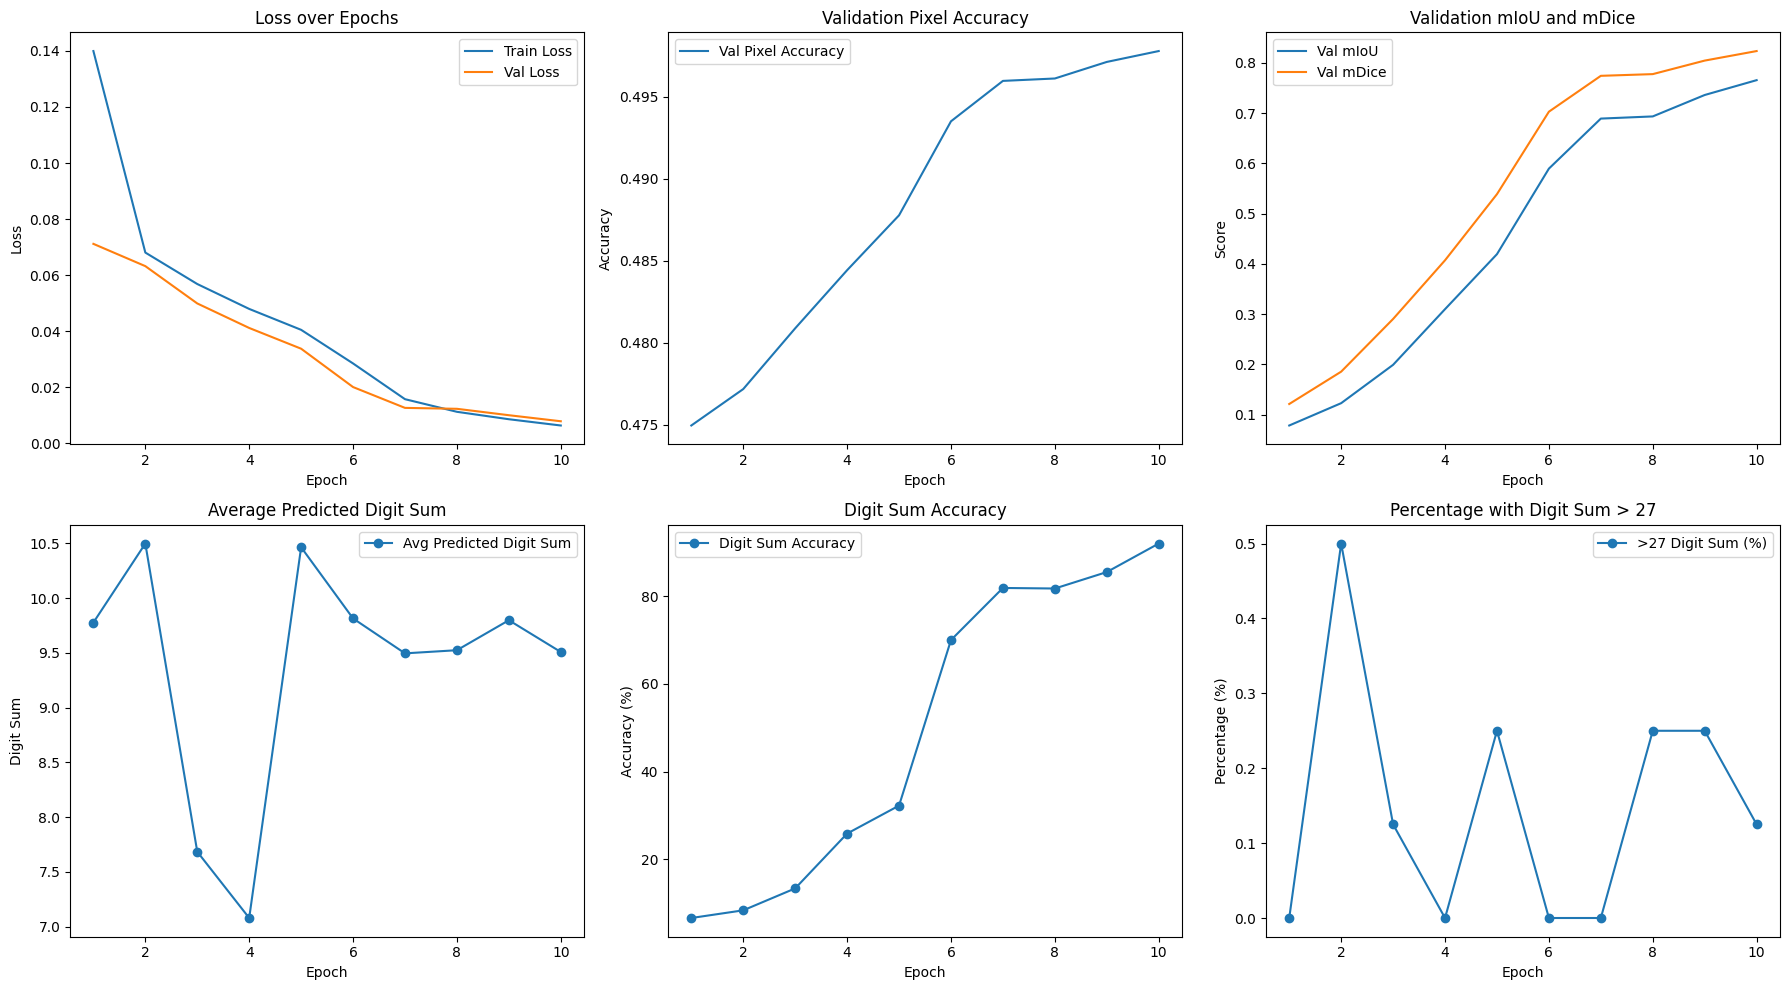

In [17]:
import matplotlib.pyplot as plt

epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(18, 10))

# Plot 1: Train vs Val Loss
plt.subplot(2, 3, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot 2: Pixel Accuracy
plt.subplot(2, 3, 2)
plt.plot(epochs_range, val_pixel_accuracies, label='Val Pixel Accuracy')
plt.title('Validation Pixel Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot 3: mIoU and mDice
plt.subplot(2, 3, 3)
plt.plot(epochs_range, val_mious, label='Val mIoU')
plt.plot(epochs_range, val_mdices, label='Val mDice')
plt.title('Validation mIoU and mDice')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()

# Plot 4: Average Predicted Digit Sum
plt.subplot(2, 3, 4)
plt.plot(epochs_range, val_digit_sums, label='Avg Predicted Digit Sum', marker='o')
plt.title('Average Predicted Digit Sum')
plt.xlabel('Epoch')
plt.ylabel('Digit Sum')
plt.legend()

# Plot 5: Digit Sum Accuracy (Predicted vs True)
plt.subplot(2, 3, 5)
plt.plot(epochs_range, val_sum_accuracy, label='Digit Sum Accuracy', marker='o')
plt.title('Digit Sum Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# Plot 6: Percentage of Images with Predicted Digit Sum >27
plt.subplot(2, 3, 6)
plt.plot(epochs_range, val_over27_pct, label='>27 Digit Sum (%)', marker='o')
plt.title('Percentage with Digit Sum > 27')
plt.xlabel('Epoch')
plt.ylabel('Percentage (%)')
plt.legend()

plt.tight_layout()
plt.show()


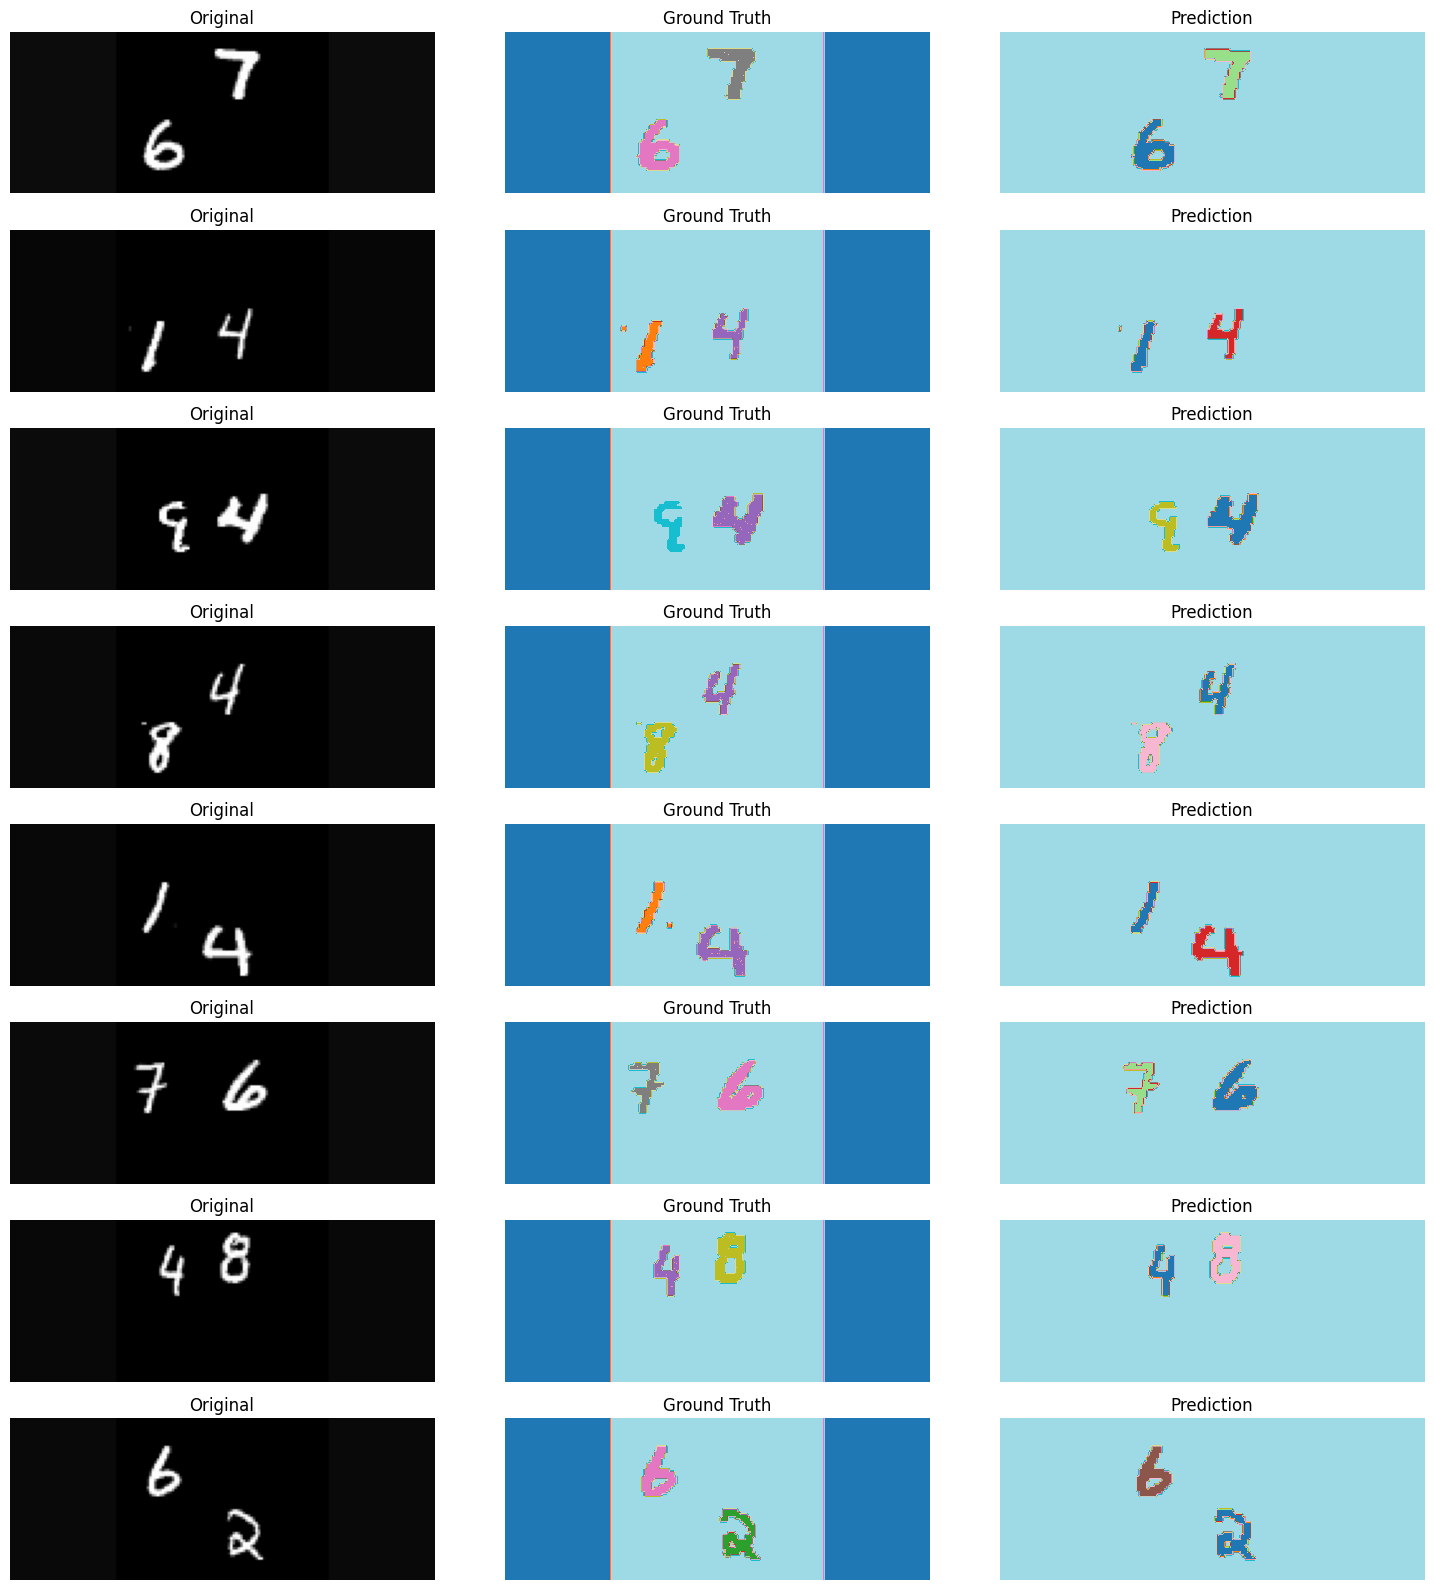

In [18]:
def visualize_batch_predictions(model, loader, device, num_images=8):
    model.eval()
    with th.no_grad():
        # Grab one batch from the loader
        images, masks = next(iter(loader))
        images = images.to(device)
        pred_logits = model(images)
        pred_labels = pred_logits.argmax(dim=1)   # shape: [N, H, W]
        masks_labels = masks.argmax(dim=1)         # shape: [N, H, W]
        
    # Move tensors to CPU for visualization
    images = images.cpu()
    pred_labels = pred_labels.cpu()
    masks_labels = masks_labels.cpu()
    
    # Plot a few examples
    plt.figure(figsize=(15, num_images * 2))
    for i in range(num_images):
        # Original image
        plt.subplot(num_images, 3, i*3 + 1)
        plt.imshow(images[i][0], cmap='gray')  # assuming channel 0 is the image; adjust if needed
        plt.title("Original")
        plt.axis('off')
        
        # Ground truth mask (using argmax labels)
        plt.subplot(num_images, 3, i*3 + 2)
        plt.imshow(masks_labels[i], cmap='tab20')
        plt.title("Ground Truth")
        plt.axis('off')
        
        # Predicted mask
        plt.subplot(num_images, 3, i*3 + 3)
        plt.imshow(pred_labels[i], cmap='tab20')
        plt.title("Prediction")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage:
visualize_batch_predictions(model, val_loader, device, num_images=8)


Test Digit Sum Accuracy: 90.6%


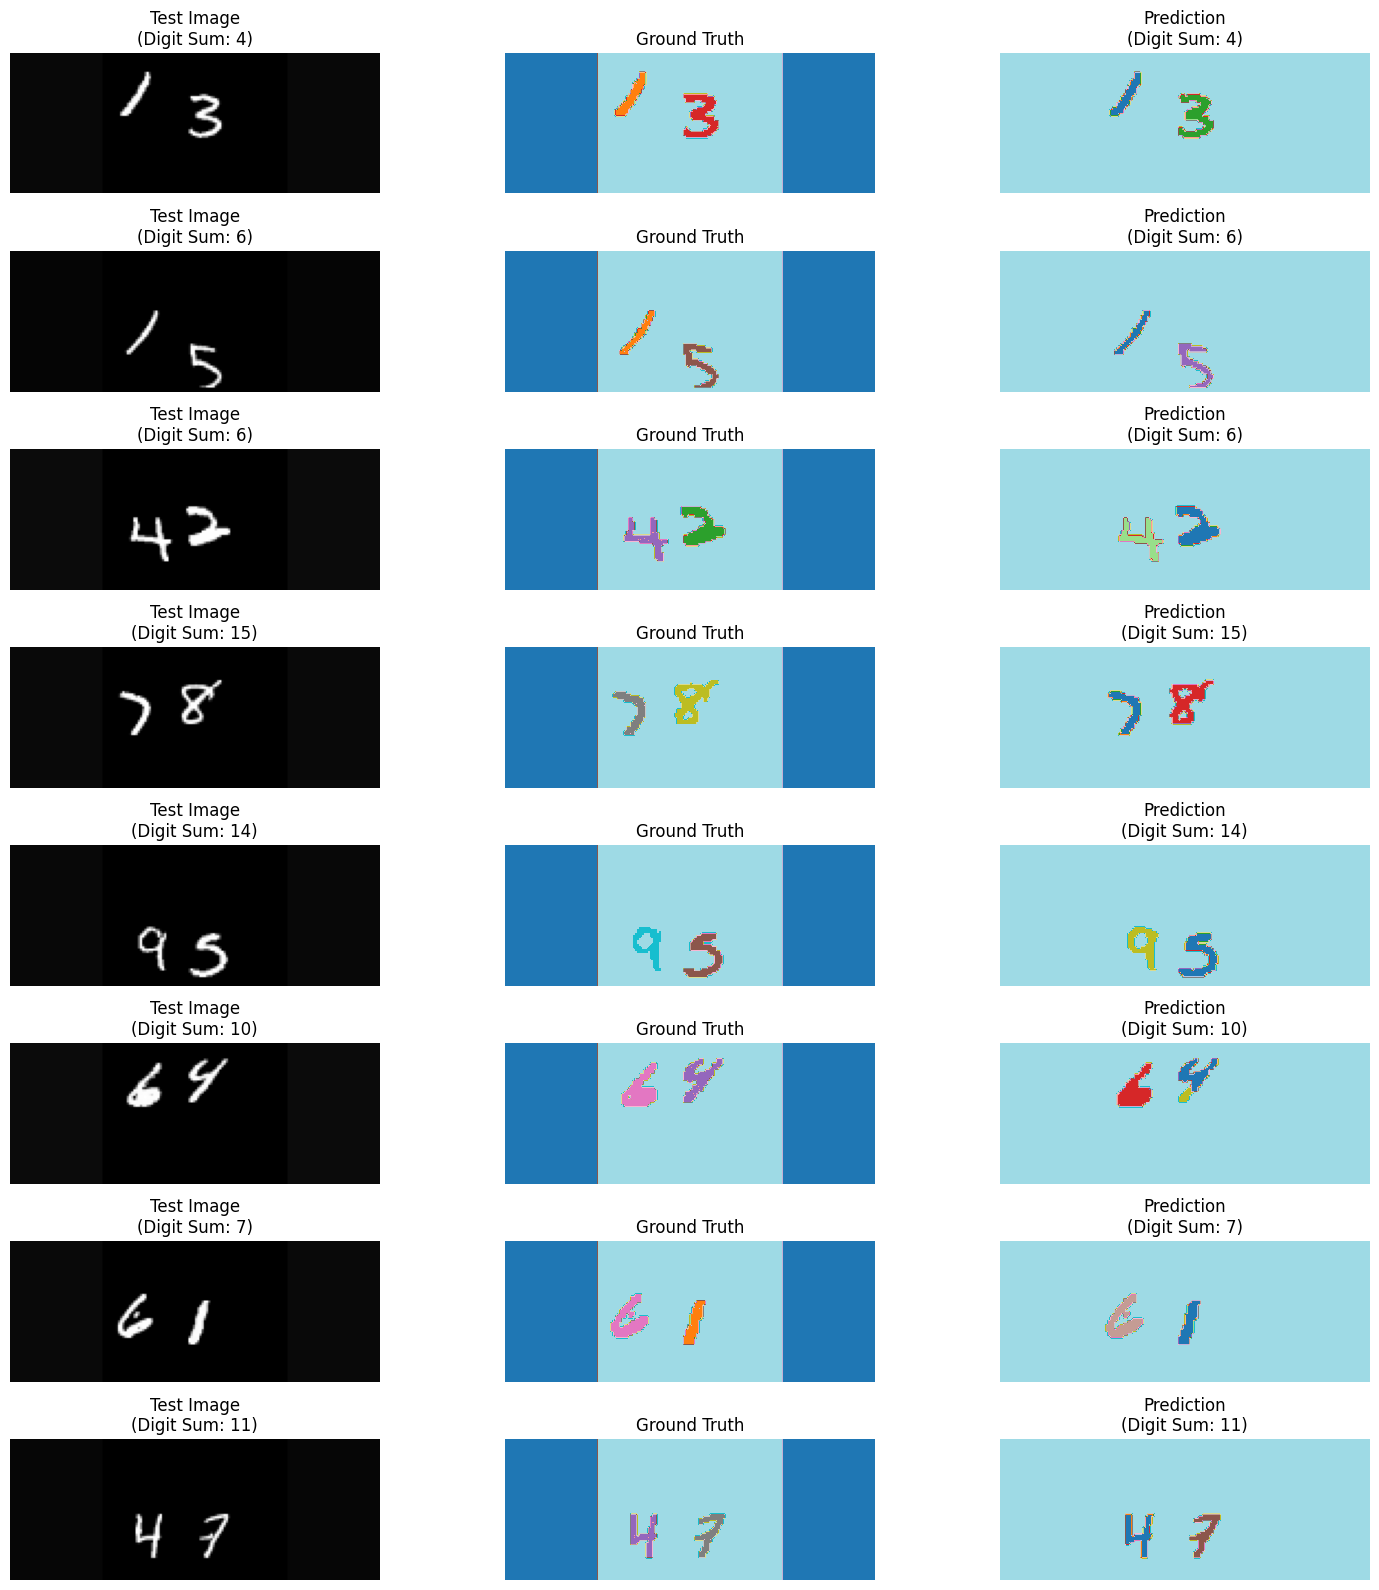

In [18]:
def test_loop(model, test_loader, device, threshold=33, num_visualize=8):
    model.eval()
    test_digit_sums = []
    test_images = []
    test_preds = []
    test_true = []
    
    with th.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            pred_logits = model(images)
            pred_labels = pred_logits.argmax(dim=1)   # [N, H, W]
            masks_labels = masks.argmax(dim=1)         # [N, H, W]
            
            # For each image in the batch, compute digit sum
            batch_size = pred_labels.size(0)
            for i in range(batch_size):
                pred_sum = compute_digit_sum_for_image_labels(pred_labels[i].cpu(), threshold)
                true_sum = compute_digit_sum_for_image_labels(masks_labels[i].cpu(), threshold)
                test_digit_sums.append((pred_sum, true_sum))
                test_images.append(images[i].cpu())
                test_preds.append(pred_labels[i].cpu())
                test_true.append(masks_labels[i].cpu())
    
    # Compute test digit sum accuracy
    test_digit_sum_acc = sum(1 for pred, true in test_digit_sums if pred == true) / len(test_digit_sums) * 100
    print(f"Test Digit Sum Accuracy: {test_digit_sum_acc:.1f}%")
    
    # Visualize a few test results
    plt.figure(figsize=(15, num_visualize * 2))
    for i in range(num_visualize):
        # Display original image
        plt.subplot(num_visualize, 3, i*3 + 1)
        plt.imshow(test_images[i][0], cmap='gray')
        plt.title(f"Test Image\n(Digit Sum: {test_digit_sums[i][1]})")
        plt.axis('off')
        
        # Ground Truth Mask
        plt.subplot(num_visualize, 3, i*3 + 2)
        plt.imshow(test_true[i], cmap='tab20')
        plt.title("Ground Truth")
        plt.axis('off')
        
        # Predicted Mask with predicted digit sum
        plt.subplot(num_visualize, 3, i*3 + 3)
        plt.imshow(test_preds[i], cmap='tab20')
        plt.title(f"Prediction\n(Digit Sum: {test_digit_sums[i][0]})")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage:
test_loop(model, test_loader, device, threshold=33, num_visualize=8)


In [ ]:
th.save(model.state_dict(),"trained_params.pt")

In [19]:
data0 = np.load("/kaggle/input/multidigittrainingdata/DL-Project/data0.npy")
data1 = np.load("/kaggle/input/multidigittrainingdata/DL-Project/data1.npy")
data2 = np.load("/kaggle/input/multidigittrainingdata/DL-Project/data2.npy")
lab0  = np.load("/kaggle/input/multidigittrainingdata/DL-Project/lab0.npy")
lab1  = np.load("/kaggle/input/multidigittrainingdata/DL-Project/lab1.npy") 
lab2  = np.load("/kaggle/input/multidigittrainingdata/DL-Project/lab2.npy") 

sumtest_data = np.concatenate((data0,data1,data2))
sumtest_sums = np.concatenate((lab0,lab1,lab2))

print(sumtest_data.shape,sumtest_sums.shape)
sumtest_data = np.pad(sumtest_data,((0,0),(24,0),(0,0)),constant_values=0)

print(sumtest_data.shape)

class DigitSumDataset(Dataset):
    def __init__(self,images,sums):
        self.images =images/255
        self.sums = sums
    def __len__(self):
        return(len(self.sums))
    def __getitem__(self,idx):
        img = self.images[idx] 
        stdimg = np.std(img)
        img = (img - np.mean(img))/stdimg ## normalizing it
        return(th.tensor(img).unsqueeze(0).float(),self.sums[idx])

sumtestset = DigitSumDataset(sumtest_data[:5000,:,:],sumtest_sums[:5000])
sumtestloader = DataLoader(sumtestset,batch_size=32)

(30000, 40, 168) (30000,)
(30000, 64, 168)


Processed: 5000, Current Accuracy: 71.48%
Final Test Digit Sum Accuracy: 71.48%

Top Failure Cases:
Predicted: 15, True: 12, Count: 17
Predicted: 20, True: 17, Count: 16
Predicted: 17, True: 22, Count: 15
Predicted: 10, True: 11, Count: 15
Predicted: 13, True: 14, Count: 14


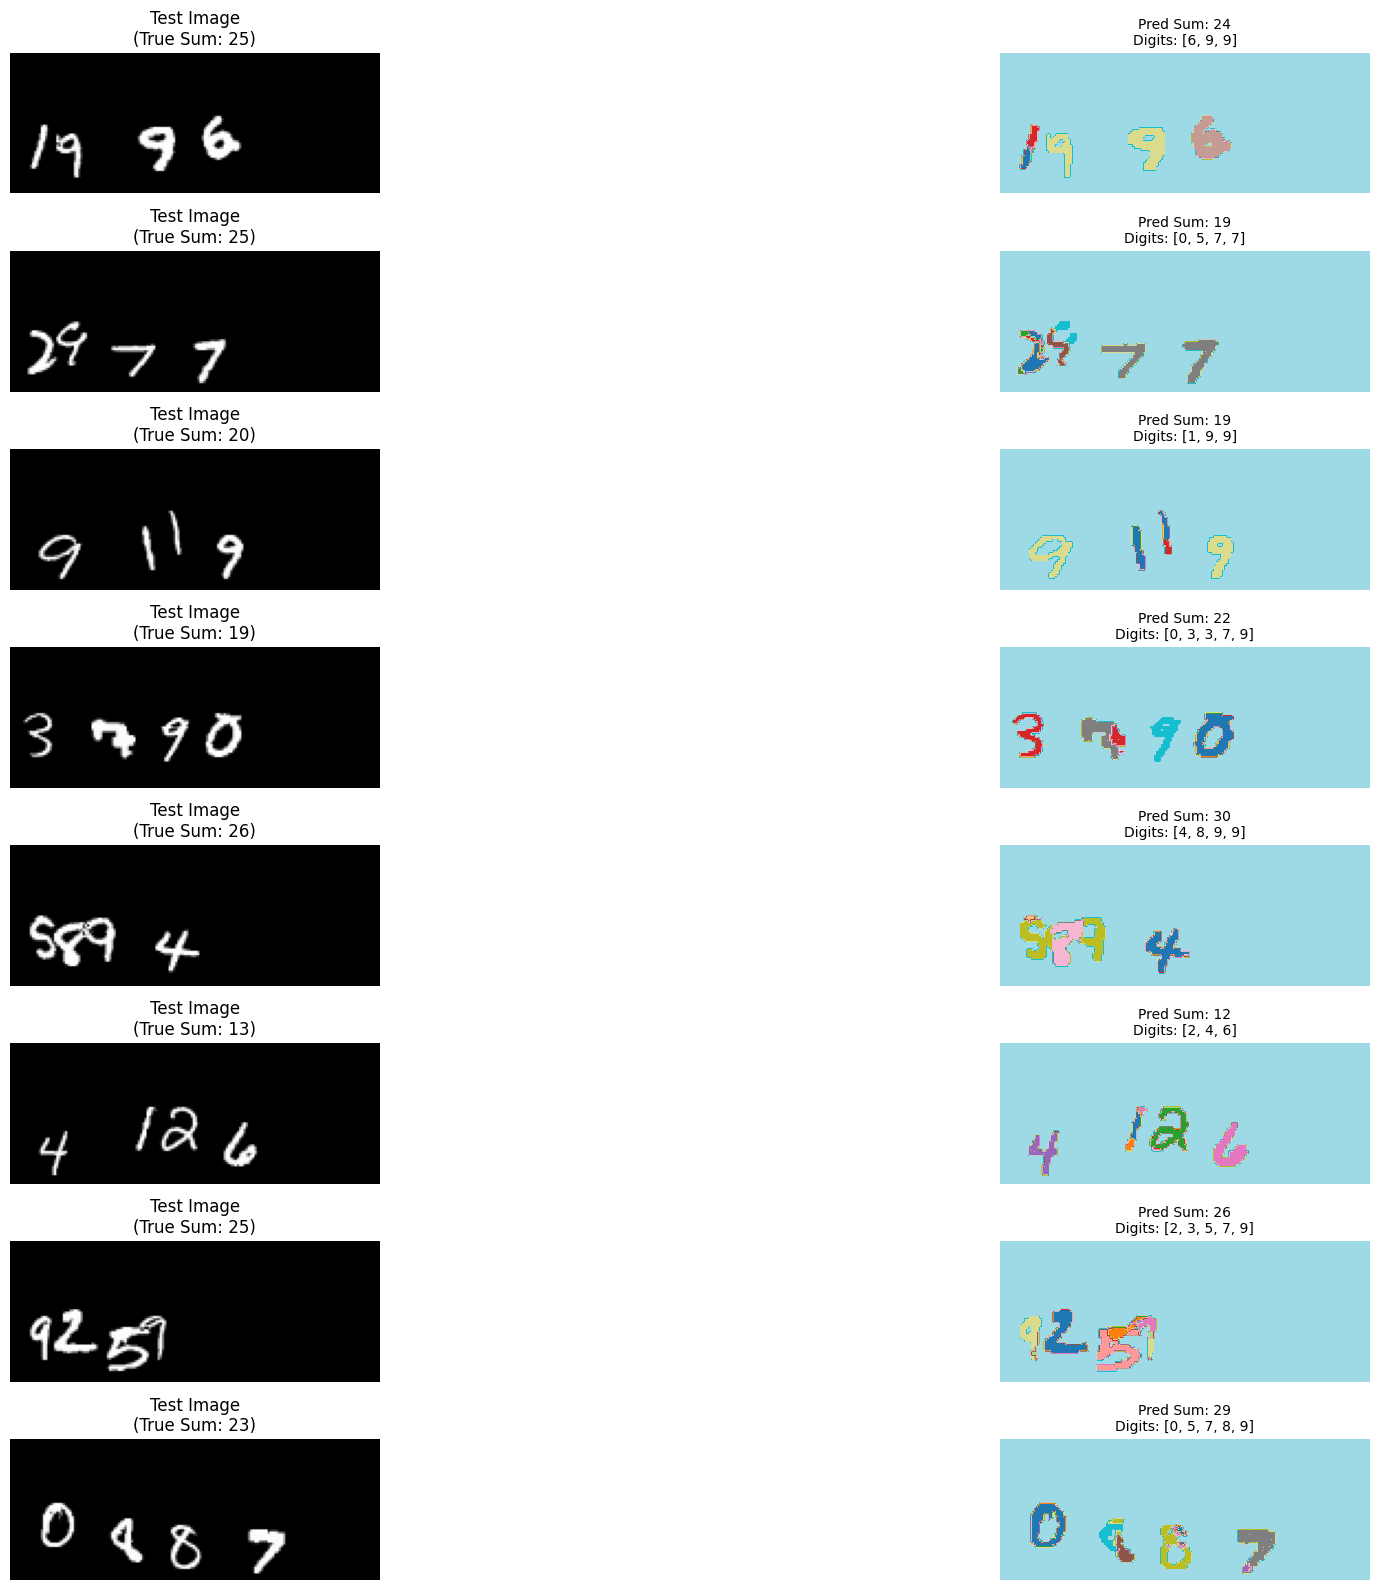

In [20]:
def sumtest_loop(model, test_loader, device, threshold=33, num_visualize=8):
    import torch as th
    import matplotlib.pyplot as plt
    from collections import Counter

    model.eval()
    test_digit_sums = []   # Stores tuples of (predicted sum, true sum)
    test_images = []       # Stores test images
    test_preds = []        # Stores predicted label masks
    test_digit_lists = []  # Stores detected digit lists for visualization
    failure_indices = []   # Stores indices where prediction fails
    running_correct = 0    # Counter for correct predictions
    running_total = 0      # Total predictions

    with th.no_grad():
        for images, sums in test_loader:
            images = images.to(device)
            pred_logits = model(images)
            pred_labels = pred_logits.argmax(dim=1)  # [N, H, W]

            batch_size = pred_labels.size(0)
            for i in range(batch_size):
                # Compute digit sum and detected digit list on CPU.
                pred_sum, digit_list = compute_digit_sum_for_image_labels_andretlabels(
                    pred_labels[i].cpu(), threshold
                )
                true_sum = sums[i].item()

                # Update metrics
                running_total += 1
                if pred_sum == true_sum:
                    running_correct += 1
                else:
                    failure_indices.append(running_total - 1)

                # Store results for every image
                test_digit_sums.append((pred_sum, true_sum))
                test_images.append(images[i].cpu())
                test_preds.append(pred_labels[i].cpu())
                test_digit_lists.append(digit_list)

                # Dynamic accuracy display (printed on the same line)
                current_acc = (running_correct / running_total) * 100
                print(f"Processed: {running_total}, Current Accuracy: {current_acc:.2f}%", end="\r")

    # Final accuracy
    final_accuracy = (running_correct / running_total) * 100
    print(f"\nFinal Test Digit Sum Accuracy: {final_accuracy:.2f}%")

    # Failure statistics
    if failure_indices:
        from collections import Counter
        failures = [test_digit_sums[idx] for idx in failure_indices]
        failure_counts = Counter(failures)
        print("\nTop Failure Cases:")
        for (pred, true), count in failure_counts.most_common(5):
            print(f"Predicted: {pred}, True: {true}, Count: {count}")
    else:
        print("No failures!")

    # Visualize only failure cases (up to num_visualize)
    num_failures = len(failure_indices)
    num_to_visualize = min(num_visualize, num_failures)
    if num_failures == 0:
        print("No failure cases to visualize.")
        return

    plt.figure(figsize=(15, num_to_visualize * 2))
    for j, idx in enumerate(failure_indices[:num_to_visualize]):
        # Original image subplot
        plt.subplot(num_to_visualize, 3, j * 3 + 1)
        plt.imshow(test_images[idx][0], cmap='gray')
        plt.title(f"Test Image\n(True Sum: {test_digit_sums[idx][1]})")
        plt.axis('off')
        
        # Predicted mask subplot
        plt.subplot(num_to_visualize, 3, j * 3 + 3)
        plt.imshow(test_preds[idx], cmap='tab20')
        annotation_text = f"Pred Sum: {test_digit_sums[idx][0]}\nDigits: {test_digit_lists[idx]}"
        plt.title(annotation_text, fontsize=10)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

sumtest_loop(model, sumtestloader, device, threshold=40, num_visualize=8)
